# Goal:

Try training LGBM with basic features (14d prediction)

Group features:
- same id, product id, name first, name second, categores, warehouse, warhouse location, combos
- all of these --> lag sales, rolling sales, etc.

Date features:
- dow, month, year, etc.
- is holiday

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
DIRECTORY = './data/'
calendar = pd.read_csv(DIRECTORY + 'calendar.csv', parse_dates=['date'])
inventory = pd.read_csv(DIRECTORY + 'inventory.csv')
test = pd.read_csv(DIRECTORY + 'sales_test.csv', parse_dates=['date'])
train = pd.read_csv(DIRECTORY + 'sales_train.csv', parse_dates=['date'])
solution = pd.read_csv(DIRECTORY + 'solution.csv')
test_weights = pd.read_csv(DIRECTORY + 'test_weights.csv')

## Set Up Initial Df - no features

In [3]:
# Initial combined df
combined = pd.concat([train, test], axis=0)
combined = combined.merge(test_weights, on='unique_id', how='left') \
    .merge(inventory.drop(columns='warehouse'), on='unique_id', how='left') \
    .merge(calendar[['date', 'holiday_name', 'holiday', 'warehouse']], on=['date', 'warehouse'], how='left')
combined_no_holidays = combined[combined['holiday'] == 0].drop(columns=['holiday', 'holiday_name']).copy()
combined_no_holidays = combined_no_holidays.sort_values(by='date')
combined_no_holidays = combined_no_holidays.reset_index(drop=True)
del calendar, inventory, test, train, solution, test_weights, combined

In [4]:
features = combined_no_holidays

## Start to add features

In [5]:
# Add categorical features for groupings
def date_features(df):
    df = df.copy()
    df['day_of_year'] = df['date'].dt.day_of_year
    df['day_of_month'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.weekday
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year

    yearly = CalendarFourier(freq='A', order=4).in_sample(df['date']).reset_index(drop=True)
    yearly.index = df.index
    monthly = CalendarFourier(freq='M', order=2).in_sample(df['date']).reset_index(drop=True)
    monthly.index = df.index
    df = pd.concat([df, yearly, monthly], axis=1)

    return df

features = date_features(features)

/Users/akhilkammila/miniconda3/envs/tradingClub/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)
/Users/akhilkammila/miniconda3/envs/tradingClub/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


In [ ]:
# Lag features
def add_shift_feature(df, groupby, shift_number):
    return df.groupby(groupby)['sales'].shift(shift_number).reset_index(level=0, drop=True)

def add_rolling_feature(df, groupby, rolling_number):
    return df.groupby(groupby)['sales'].rolling(rolling_number, closed='left', min_periods=1).mean().shift(14)

def add_days_ago_feature(df, groupby, days_ago):
    date_shift_df = df[groupby + ['date', 'sales']].copy()
    date_shift_df['date'] = date_shift_df['date'] + pd.Timedelta(f'{days_ago}D')
    date_shift_df = date_shift_df.rename(columns={'sales': 'new_col'})

    df = df.merge(date_shift_df, on=groupby + ['date'], how='left')
    return df['new_col'].reset_index(level=0, drop=True)

# groupings = [['unique_id'], ['name'], ['L1_category_name_en'], ['L2_category_name_en'],['L3_category_name_en'],['L4_category_name_en']]

# shift_nums = [14, 15, 21, 365]
# rolling_nums = [1, 2, 7, 31]

# for grouping in [['unique_id']]:
#     grouping_string = f'({'_'.join(grouping)})'
#     for shift in shift_nums:
#         features[f'{grouping_string}_shift_{shift}d'] = add_shift_feature(features, grouping, shift)
#     for rolling in rolling_nums:
#         features[f'{grouping_string}_rolling_{rolling}d'] = add_rolling_feature(features, grouping, shift)


In [60]:
# Don't use functions. First check what result we WANT, then test one by one
display(features[features['unique_id'] == 3841][['unique_id', 'date', 'sales']].head(20))

# So after adding our new shift feature, we know what we want to see
features['test_shift'] = add_shift_feature(features, ['unique_id'], 1)
features[features['unique_id'] == 3841][['unique_id', 'date', 'sales', 'test_shift']].head(20)

# Now we test our rolling feature
features['test_rolling'] = add_rolling_feature(features, ['unique_id'], 2)
features[features['unique_id'] == 3841][['unique_id', 'date', 'sales', 'test_rolling']].head(20)

,unique_id,date,sales
0,3841,2020-08-01,40.58
2217,3841,2020-08-02,24.20
4816,3841,2020-08-03,47.47
6755,3841,2020-08-04,54.83
8740,3841,2020-08-05,37.12
10771,3841,2020-08-06,16.76
11785,3841,2020-08-07,29.54
14116,3841,2020-08-08,48.74
15839,3841,2020-08-09,58.58
18462,3841,2020-08-10,57.46


ValueError: Columns must be same length as key

In [ ]:
grouping = features.groupby(['unique_id'])['sales'].rolling(2, closed='left', min_periods=1).mean()
grouping = grouping.shift(1).reset_index(level=0, drop=True).sort_index()
# grouping.reset_index(drop=True).reset_index(drop=True)

nan

In [45]:
## Final Processing

def fix_df(df):
    # Change index to month, remove date
    if 'date' in df.columns:
        df.index = df['date'].dt.to_period('M')
        df = df.drop(columns='date')
    # can add an else assert
    df = df.sort_index()

    # Fix categoricals
    categorical = list(df.select_dtypes(include='object').columns)
    for col in categorical:
        df[col] = df[col].astype('category')

    # Rename features
    df.columns = df.columns.str.replace(r'["{}[\]:,\\]', '_', regex=True)
    return df

features = fix_df(features)

## Testing LGBM

In [46]:
# For below to work, index has to be months, and 'date' cannot be a col
# No ( and , in column names
features.head()

,unique_id,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,...,cos(2_freq=YE-DEC),sin(3_freq=YE-DEC),cos(3_freq=YE-DEC),sin(4_freq=YE-DEC),cos(4_freq=YE-DEC),sin(1_freq=ME),cos(1_freq=ME),sin(2_freq=ME),cos(2_freq=ME),previous_sale
date,,,,,,,,,,,,,,,,,,,,,
2020-08,3841,Prague_1,4111.0,40.58,37.69,1.0,0.0,0.0,0.0,0.0,...,0.514793,-0.999668,-0.025748,0.882679,-0.469977,0.0,1.0,0.0,1.0,NaN
2020-08,3303,Brno_1,4797.0,35.62,23.72,1.0,0.0,0.0,0.0,0.0,...,0.514793,-0.999668,-0.025748,0.882679,-0.469977,0.0,1.0,0.0,1.0,NaN
2020-08,700,Prague_1,4111.0,23.87,10.61,1.0,0.0,0.0,0.0,0.0,...,0.514793,-0.999668,-0.025748,0.882679,-0.469977,0.0,1.0,0.0,1.0,NaN
2020-08,830,Prague_3,2466.0,14.27,11.40,1.0,0.0,0.0,0.0,0.0,...,0.514793,-0.999668,-0.025748,0.882679,-0.469977,0.0,1.0,0.0,1.0,NaN
2020-08,1841,Prague_3,2416.0,13.33,32.63,0.6,0.0,0.0,0.0,0.0,...,0.514793,-0.999668,-0.025748,0.882679,-0.469977,0.0,1.0,0.0,1.0,NaN


In [20]:
model = lgb.LGBMRegressor()

months = np.sort(features.index.unique())
test_month_indices = np.arange(-2, -10, -1)
test_month_indices = [-2]
for test_month_index in test_month_indices:
    test_month = months[test_month_index]
    train_end = test_month - 1

    train = features.loc[:train_end]
    test = features.loc[test_month]

    categorical = list(features.select_dtypes(include='category').columns)

    train_data = lgb.Dataset(train.drop(columns=['sales', 'weight']), label=train['sales'], weight=train['weight'], categorical_feature=categorical)
    test_data = lgb.Dataset(test.drop(columns=['sales', 'weight']), label=test['sales'], weight=test['weight'], categorical_feature=categorical)
    params = {"objective": "regression", "metric": "mse"}
    model = lgb.train(
        params=params,
        train_set=train_data,
        valid_sets=[test_data],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=True),  # Stops if no improvement in 50 rounds
            lgb.log_evaluation(period=100)  # Logs every 10 iterations
        ]
    )

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7567
[LightGBM] [Info] Number of data points in the train set: 3740399, number of used features: 36
[LightGBM] [Info] Start training from score 74.094929
Training until validation scores don't improve for 50 rounds
[100]	valid_0's l2: 2580.5
[200]	valid_0's l2: 2440.59
[300]	valid_0's l2: 2334.67
[400]	valid_0's l2: 2285.41
[500]	valid_0's l2: 2259.04
Early stopping, best iteration is:
[533]	valid_0's l2: 2254.35


In [25]:
train_preds = model.predict(train.drop(columns=['sales', 'weight']))
test_preds = model.predict(test.drop(columns=['sales', 'weight']))

ValueError: Input contains NaN.

In [30]:
train_error = mean_absolute_error(train['sales'].fillna(0), train_preds, sample_weight=train['weight'])
test_error = mean_absolute_error(test['sales'].fillna(0), test_preds, sample_weight=test['weight'])

print(f"Train MAE: {train_error:.4f}")
print(f"Test MAE: {test_error:.4f}")

Train MAE: 15.7426
Test MAE: 18.9836


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

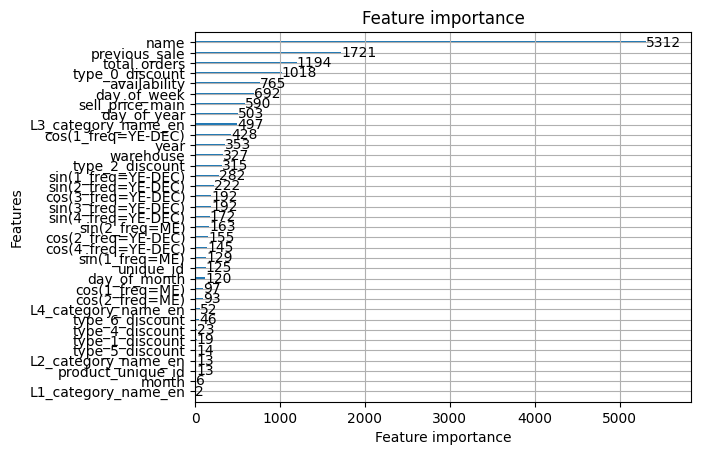

In [53]:
lgb.plot_importance(model)

## What is contributing to the error?

What do my predictions look like; am I even in the right range?

model.